# UAS ML: Forecasting Produksi Padi Jabar with Holt-Winters

Plan:
- Load CSV and parse date/time
- Clean data: handle missing/duplicates/outliers; set Date index
- Visualize series and seasonality
- Fit Holt-Winters (ExponentialSmoothing) with suitable seasonal period
- Forecast horizon and evaluate (MAE, RMSE, MAPE)
- Plot forecasts; save cleaned data and forecast outputs

In [2]:
# Setup and imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Helper to ensure strictly positive values for multiplicative ETS
def ensure_strictly_positive(s, eps=None):
    s = s.astype(float).copy()
    if eps is None:
        pos = s[s > 0]
        base = float(pos.median()) if len(pos) > 0 else 1.0
        eps = max(1e-6, base * 1e-6)
    s[s <= 0] = eps
    return s, eps

In [4]:
# Load CSV and initial inspect
csv_path = Path('produksi_padi_jabar.csv')
# File appears to use semicolon as delimiter
df = pd.read_csv(csv_path, sep=';')
print('Shape:', df.shape)
df.head()

Shape: (1944, 9)


,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,bulan,produksi_padi,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,JANUARI,25475,TON GABAH KERING GILING,2018
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,FEBRUARI,25290,TON GABAH KERING GILING,2018
2,3,32,JAWA BARAT,3201,KABUPATEN BOGOR,MARET,44928,TON GABAH KERING GILING,2018
3,4,32,JAWA BARAT,3201,KABUPATEN BOGOR,APRIL,39470,TON GABAH KERING GILING,2018
4,5,32,JAWA BARAT,3201,KABUPATEN BOGOR,MEI,36418,TON GABAH KERING GILING,2018


In [5]:
# Cleaning and preprocessing for per-kabupaten/month/year forecasting
# Standardize column names to lowercase
df.columns = [str(c).strip().lower() for c in df.columns]

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

required_cols = {'bulan','tahun','produksi_padi','nama_kabupaten_kota'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Kolom wajib hilang: {missing}. Pastikan header sesuai: {required_cols}")

# Map Indonesian month names to numbers
bulan_map = {
    'JANUARI': 1, 'FEBRUARI': 2, 'MARET': 3, 'APRIL': 4, 'MEI': 5, 'JUNI': 6,
    'JULI': 7, 'AGUSTUS': 8, 'SEPTEMBER': 9, 'OKTOBER': 10, 'NOVEMBER': 11, 'DESEMBER': 12,
    # lowercase variants
    'januari': 1, 'februari': 2, 'maret': 3, 'april': 4, 'mei': 5, 'juni': 6,
    'juli': 7, 'agustus': 8, 'september': 9, 'oktober': 10, 'november': 11, 'desember': 12
}

# Coerce year and month
df['tahun'] = pd.to_numeric(df['tahun'], errors='coerce')
df['bulan_num'] = df['bulan'].map(bulan_map).fillna(pd.to_numeric(df['bulan'], errors='coerce'))

# Build a date (use first day of month)
df['date_parsed'] = pd.to_datetime(dict(year=df['tahun'], month=df['bulan_num'], day=1), errors='coerce')

# Ensure numeric produksi
df['produksi_padi'] = pd.to_numeric(df['produksi_padi'].astype(str).str.replace(',','.'), errors='coerce')

# Normalize kabupaten name
df['nama_kabupaten_kota'] = df['nama_kabupaten_kota'].astype(str).str.strip()

# Drop invalid rows
df = df.dropna(subset=['date_parsed','produksi_padi','nama_kabupaten_kota']).copy()

# Aggregate to unique (kabupaten, month) in case of duplicates
df = (df.groupby(['nama_kabupaten_kota','tahun','bulan_num','date_parsed'], as_index=False)['produksi_padi']
        .sum())

# Sort for stable ordering
df = df.sort_values(['nama_kabupaten_kota','date_parsed'])

# Winsorize extreme outliers per kabupaten (1% tails)
def winsorize_group(g):
    q_low, q_high = g['produksi_padi'].quantile([0.01, 0.99])
    g['produksi_padi'] = g['produksi_padi'].clip(lower=q_low, upper=q_high)
    return g
df = df.groupby('nama_kabupaten_kota', group_keys=False).apply(winsorize_group)

# Save a cleaned all-kabupaten dataset including explicit columns without index
clean_all_path = Path('cleaned_produksi_padi_semua_kabupaten.csv')
df_to_save = df.rename(columns={'bulan_num':'bulan','nama_kabupaten_kota':'nama_provinsi'})
df_to_save.to_csv(clean_all_path, index=False)
print('Saved cleaned all-kabupaten CSV:', clean_all_path)

print('Cleaned shape:', df.shape)
df.head()

Saved cleaned all-kabupaten CSV: cleaned_produksi_padi_semua_kabupaten.csv
Cleaned shape: (1944, 5)


C:\Users\USER\AppData\Local\Temp\ipykernel_18028\819866073.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('nama_kabupaten_kota', group_keys=False).apply(winsorize_group)


,nama_kabupaten_kota,tahun,bulan_num,date_parsed,produksi_padi
0,KABUPATEN BANDUNG,2018,1,2018-01-01,5356.41
1,KABUPATEN BANDUNG,2018,2,2018-02-01,20625.00
2,KABUPATEN BANDUNG,2018,3,2018-03-01,26289.00
3,KABUPATEN BANDUNG,2018,4,2018-04-01,72600.08
4,KABUPATEN BANDUNG,2018,5,2018-05-01,25796.00


In [6]:
# Missing value handling: hybrid interpolation
# - Convert all zeros to NaN (missing)
# - Complete monthly grid
# - First pass: fill isolated single-month gaps with (prev + next) / 2
# - Second pass: linear interpolation for longer gaps and edges

# Convert all zeros to NaN unconditionally
zero_before = int((df['produksi_padi'] == 0).sum())
df.loc[df['produksi_padi'] == 0, 'produksi_padi'] = np.nan
print('Converted zeros to NaN:', zero_before)

# Complete monthly grid per kabupaten

def complete_monthly_grid(df_in: pd.DataFrame) -> pd.DataFrame:
    min_date = df_in['date_parsed'].min()
    max_date = df_in['date_parsed'].max()
    full_months = pd.date_range(min_date, max_date, freq='MS')
    frames = []
    for kab, g in df_in.groupby('nama_kabupaten_kota'):
        g = g.set_index('date_parsed').sort_index()
        g = g.reindex(full_months)
        g['nama_kabupaten_kota'] = kab
        g['tahun'] = g.index.year
        g['bulan_num'] = g.index.month
        frames.append(g.reset_index().rename(columns={'index':'date_parsed'}))
    return pd.concat(frames, ignore_index=True)

df = complete_monthly_grid(df)

# Interpolate per kabupaten with hybrid strategy

def interpolate_kab(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values('date_parsed')
    s = g['produksi_padi'].astype(float).copy()
    vals = s.values
    # First pass: fill isolated single NaN where neighbors exist
    for i in range(1, len(vals) - 1):
        if np.isnan(vals[i]) and (not np.isnan(vals[i-1])) and (not np.isnan(vals[i+1])):
            vals[i] = (vals[i-1] + vals[i+1]) / 2.0
    s = pd.Series(vals, index=g['date_parsed'])
    # Second pass: linear interpolation for remaining gaps (including edges/longer runs)
    s = s.interpolate(method='linear', limit_direction='both')
    g['produksi_padi'] = s.values
    return g

df = df.groupby('nama_kabupaten_kota', group_keys=False).apply(interpolate_kab)

# Optional: drop rows still missing (extremely sparse tails)
before = len(df)
df = df.dropna(subset=['produksi_padi'])
after = len(df)
print(f'Hybrid interpolation: dropped rows {before - after}, final shape: {df.shape}')
df.head()

# Save unified cleaned CSV without index
clean_all_path = Path('cleaned_produksi_padi_semua_kabupaten.csv')
df_to_save = df.rename(columns={'bulan_num':'bulan','nama_kabupaten_kota':'nama_provinsi'})
df_to_save.to_csv(clean_all_path, index=False)
print('Saved cleaned CSV:', clean_all_path)

Converted zeros to NaN: 126
Hybrid interpolation: dropped rows 0, final shape: (1944, 5)
Saved cleaned CSV: cleaned_produksi_padi_semua_kabupaten.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_18028\1773788723.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('nama_kabupaten_kota', group_keys=False).apply(interpolate_kab)


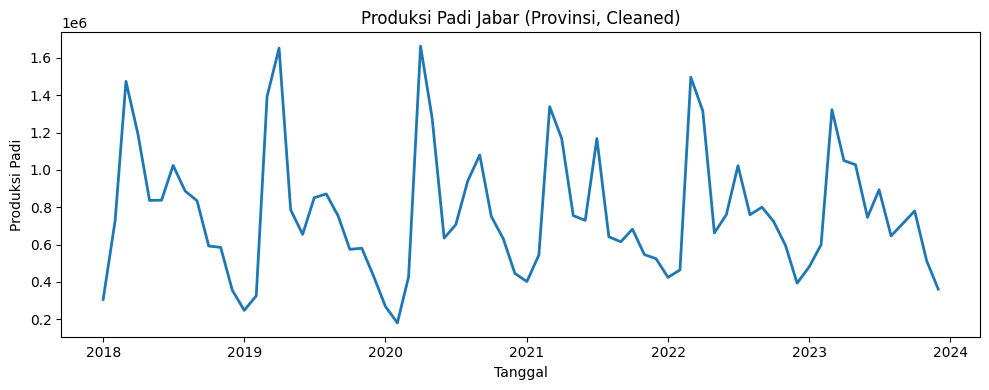

In [7]:
# Visualization (province-wide total per month)
# Build province-wide monthly series from cleaned all-kabupaten table
prov = (df.groupby('date_parsed', as_index=False)['produksi_padi'].sum()
          .sort_values('date_parsed'))
plt.figure(figsize=(10,4))
sns.lineplot(x=prov['date_parsed'], y=prov['produksi_padi'], linewidth=2)
plt.title('Produksi Padi Jabar (Provinsi, Cleaned)')
plt.xlabel('Tanggal')
plt.ylabel('Produksi Padi')
plt.tight_layout()
plt.show()

Seasonal periods: 12
                       ExponentialSmoothing Model Results                       
Dep. Variable:            produksi_padi   No. Observations:                   65
Model:             ExponentialSmoothing   SSE                  2188202142490.012
Optimized:                         True   AIC                           1607.581
Trend:                         Additive   BIC                           1642.372
Seasonal:                Multiplicative   AICC                          1622.451
Seasonal Periods:                    12   Date:                 Sat, 29 Nov 2025
Box-Cox:                          False   Time:                         13:46:38
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0399531                alpha                 True
smoo

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


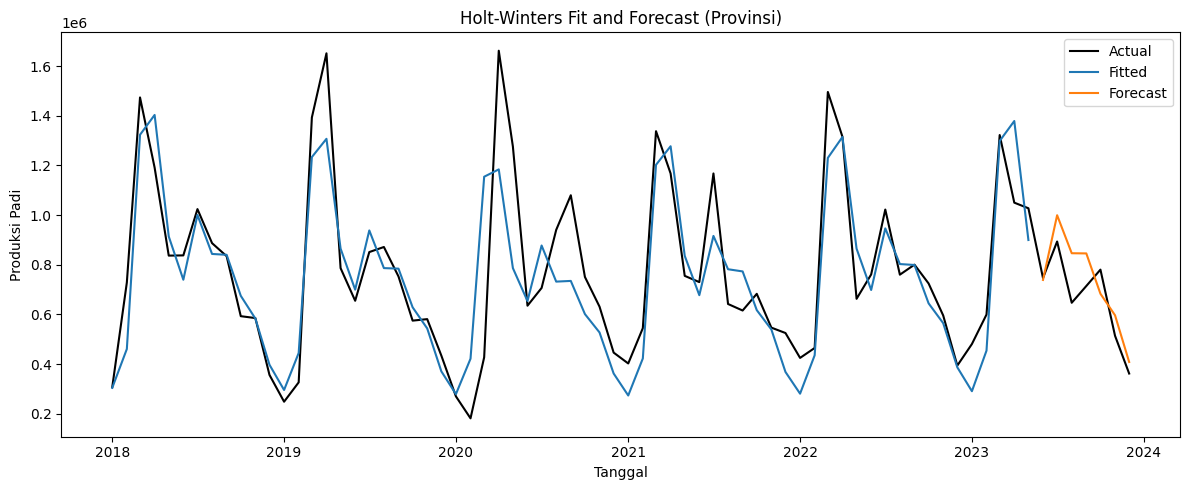

Saved forecast: forecast_produksi_padi_jabar.csv


In [8]:
# Holt-Winters modeling and forecasting (province-wide)
# Build province-wide monthly series
prov_series = (df.groupby('date_parsed', as_index=False)['produksi_padi'].sum()
                 .sort_values('date_parsed'))
prov_series = prov_series.set_index('date_parsed')['produksi_padi'].astype(float)

# Ensure monthly frequency
inferred = pd.infer_freq(prov_series.index)
if inferred is None:
    prov_series = prov_series.resample('MS').sum().interpolate(method='linear')
    freq = 'MS'
else:
    freq = inferred

series = prov_series
# Ensure strictly positive values for multiplicative ETS
series, _eps = ensure_strictly_positive(series)

# Determine seasonal period: assume monthly yearly seasonality
seasonal_periods = 12 if ('M' in str(freq) or freq in ['MS','M']) else (52 if 'W' in str(freq) else (365 if 'D' in str(freq) else 12))
print('Seasonal periods:', seasonal_periods)

# Train-test split (last 12 periods as test if possible)
h = min(12, max(1, len(series)//10))
train = series.iloc[:-h] if h > 0 else series
test = series.iloc[-h:] if h > 0 else pd.Series(dtype=float)

# Fit Holt-Winters
model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=seasonal_periods, initialization_method='estimated')
fit = model.fit(optimized=True)
print(fit.summary())

# In-sample fitted and out-of-sample forecast
fitted = fit.fittedvalues
forecast = fit.forecast(h) if h > 0 else pd.Series(dtype=float)

# Evaluation
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-8, y_true))) * 100

metrics = {}
if h > 0 and len(test) > 0:
    metrics['MAE'] = float(mean_absolute_error(test, forecast))
    metrics['RMSE'] = float(np.sqrt(mean_squared_error(test, forecast)))
    metrics['MAPE'] = float(mape(test, forecast))
    print('Metrics:', metrics)
else:
    print('Not enough data for holdout evaluation.')

# Plot fitted and forecast
plt.figure(figsize=(12,5))
plt.plot(series.index, series.values, label='Actual', color='black')
plt.plot(fitted.index, fitted.values, label='Fitted', color='tab:blue')
if h > 0:
    plt.plot(test.index, forecast.values, label='Forecast', color='tab:orange')
plt.title('Holt-Winters Fit and Forecast (Provinsi)')
plt.xlabel('Tanggal')
plt.ylabel('Produksi Padi')
plt.legend()
plt.tight_layout()
plt.show()

# Save outputs: use only cleaned_produksi_padi_semua_kabupaten.csv
forecast_path = Path('forecast_produksi_padi_jabar.csv')
if h > 0:
    pd.DataFrame({'tanggal': test.index, 'actual': test.values, 'forecast': forecast.values}).to_csv(forecast_path, index=False)
print('Saved forecast:', forecast_path)

In [9]:
# Helper: build per-kabupaten monthly series and forecast function
from typing import Tuple, Dict

# Get list of kabupaten/kota
kabupaten_list = sorted(df['nama_kabupaten_kota'].unique())
print('Kabupaten/Kota tersedia:', len(kabupaten_list))
print(kabupaten_list[:10], '...')

def build_series_for_kab(df_all: pd.DataFrame, kab: str) -> Tuple[pd.Series, str]:
    sub = df_all[df_all['nama_kabupaten_kota'] == kab].copy()
    sub = sub.sort_values('date_parsed')
    # set monthly index with first day of month
    sub = sub.set_index('date_parsed')
    # ensure monthly frequency; use sum for production
    inferred = pd.infer_freq(sub.index)
    if inferred is None:
        sub = sub.resample('MS')['produksi_padi'].sum().interpolate(method='linear')
        freq_local = 'MS'
    else:
        freq_local = inferred
        sub = sub['produksi_padi']
    return sub.astype(float), freq_local

def holt_winters_forecast(series: pd.Series, freq_str: str, horizon: int = 12) -> Dict[str, any]:
    # Ensure strictly positive values for multiplicative ETS
    series, _eps = ensure_strictly_positive(series)
    seasonal_periods = 12 if ('M' in str(freq_str) or freq_str in ['MS','M']) else (52 if 'W' in str(freq_str) else (365 if 'D' in str(freq_str) else 12))
    train = series.iloc[:-horizon] if len(series) > horizon else series
    test = series.iloc[-horizon:] if len(series) > horizon else pd.Series(dtype=float)
    model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=seasonal_periods, initialization_method='estimated')
    fit = model.fit(optimized=True)
    fitted = fit.fittedvalues
    forecast = fit.forecast(len(test)) if len(test) > 0 else fit.forecast(horizon)
    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-8, y_true))) * 100
    metrics = None
    if len(test) > 0:
        metrics = {
            'MAE': float(mean_absolute_error(test, forecast)),
            'RMSE': float(np.sqrt(mean_squared_error(test, forecast))),
            'MAPE': float(mape(test, forecast))
        }
    return {
        'fit': fit,
        'fitted': fitted,
        'forecast': forecast,
        'test': test,
        'metrics': metrics,
        'seasonal_periods': seasonal_periods
    }


Kabupaten/Kota tersedia: 27
['KABUPATEN BANDUNG', 'KABUPATEN BANDUNG BARAT', 'KABUPATEN BEKASI', 'KABUPATEN BOGOR', 'KABUPATEN CIAMIS', 'KABUPATEN CIANJUR', 'KABUPATEN CIREBON', 'KABUPATEN GARUT', 'KABUPATEN INDRAMAYU', 'KABUPATEN KARAWANG'] ...


In [10]:
# Batch: generate forecasts for all kabupaten/kota
horizon_all = 12
all_rows = []
for kab in kabupaten_list:
    series_kab, freq_kab = build_series_for_kab(df, kab)
    res = holt_winters_forecast(series_kab, freq_kab, horizon=horizon_all)
    # Create future index if needed
    if len(res['test']) > 0:
        out_index = res['test'].index
    else:
        out_index = pd.date_range(series_kab.index.max() + pd.offsets.MonthBegin(1), periods=horizon_all, freq='MS')
    # Collect rows
    for dt, fc in zip(out_index, res['forecast'].values):
        all_rows.append({'nama_kabupaten_kota': kab, 'tanggal': dt, 'forecast': fc})

df_forecasts_all = pd.DataFrame(all_rows)
df_forecasts_all = df_forecasts_all.sort_values(['nama_kabupaten_kota','tanggal'])
all_forecast_path = Path('forecast_produksi_padi_semua_kabupaten.csv')
df_forecasts_all.to_csv(all_forecast_path, index=False)
print('Saved batch forecasts:', all_forecast_path)

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\si

Saved batch forecasts: forecast_produksi_padi_semua_kabupaten.csv


Total kabupaten: 27; pages: 3


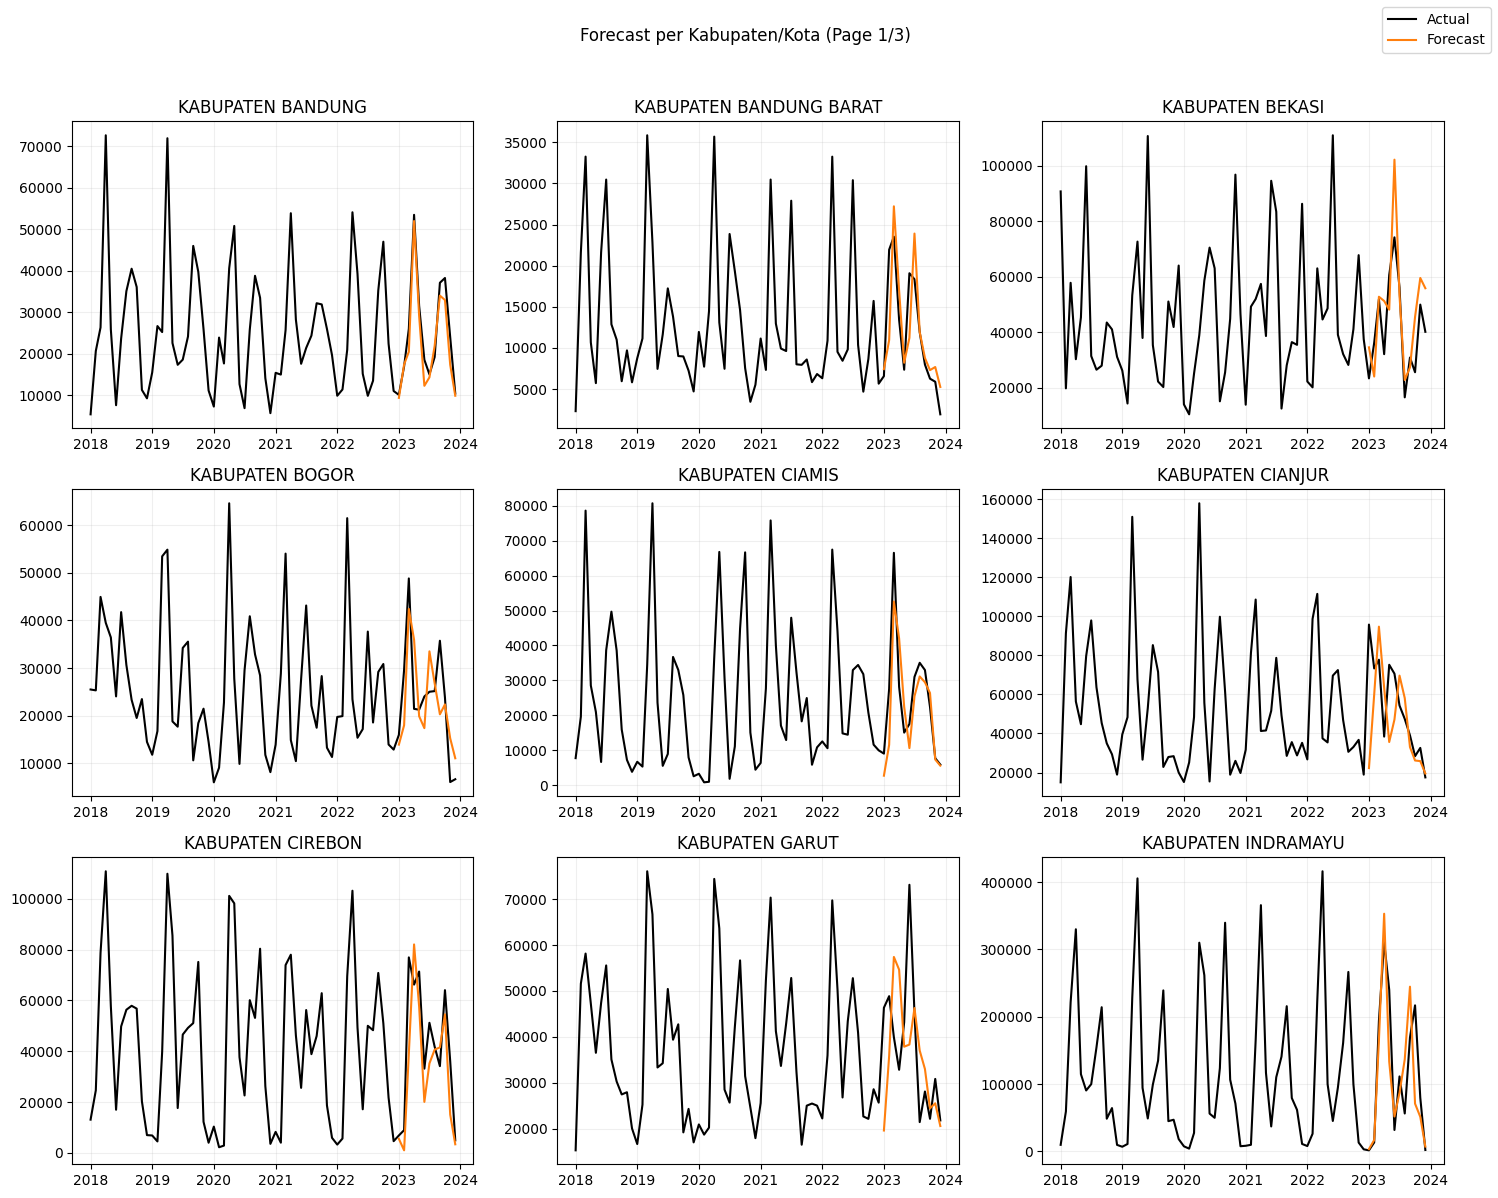

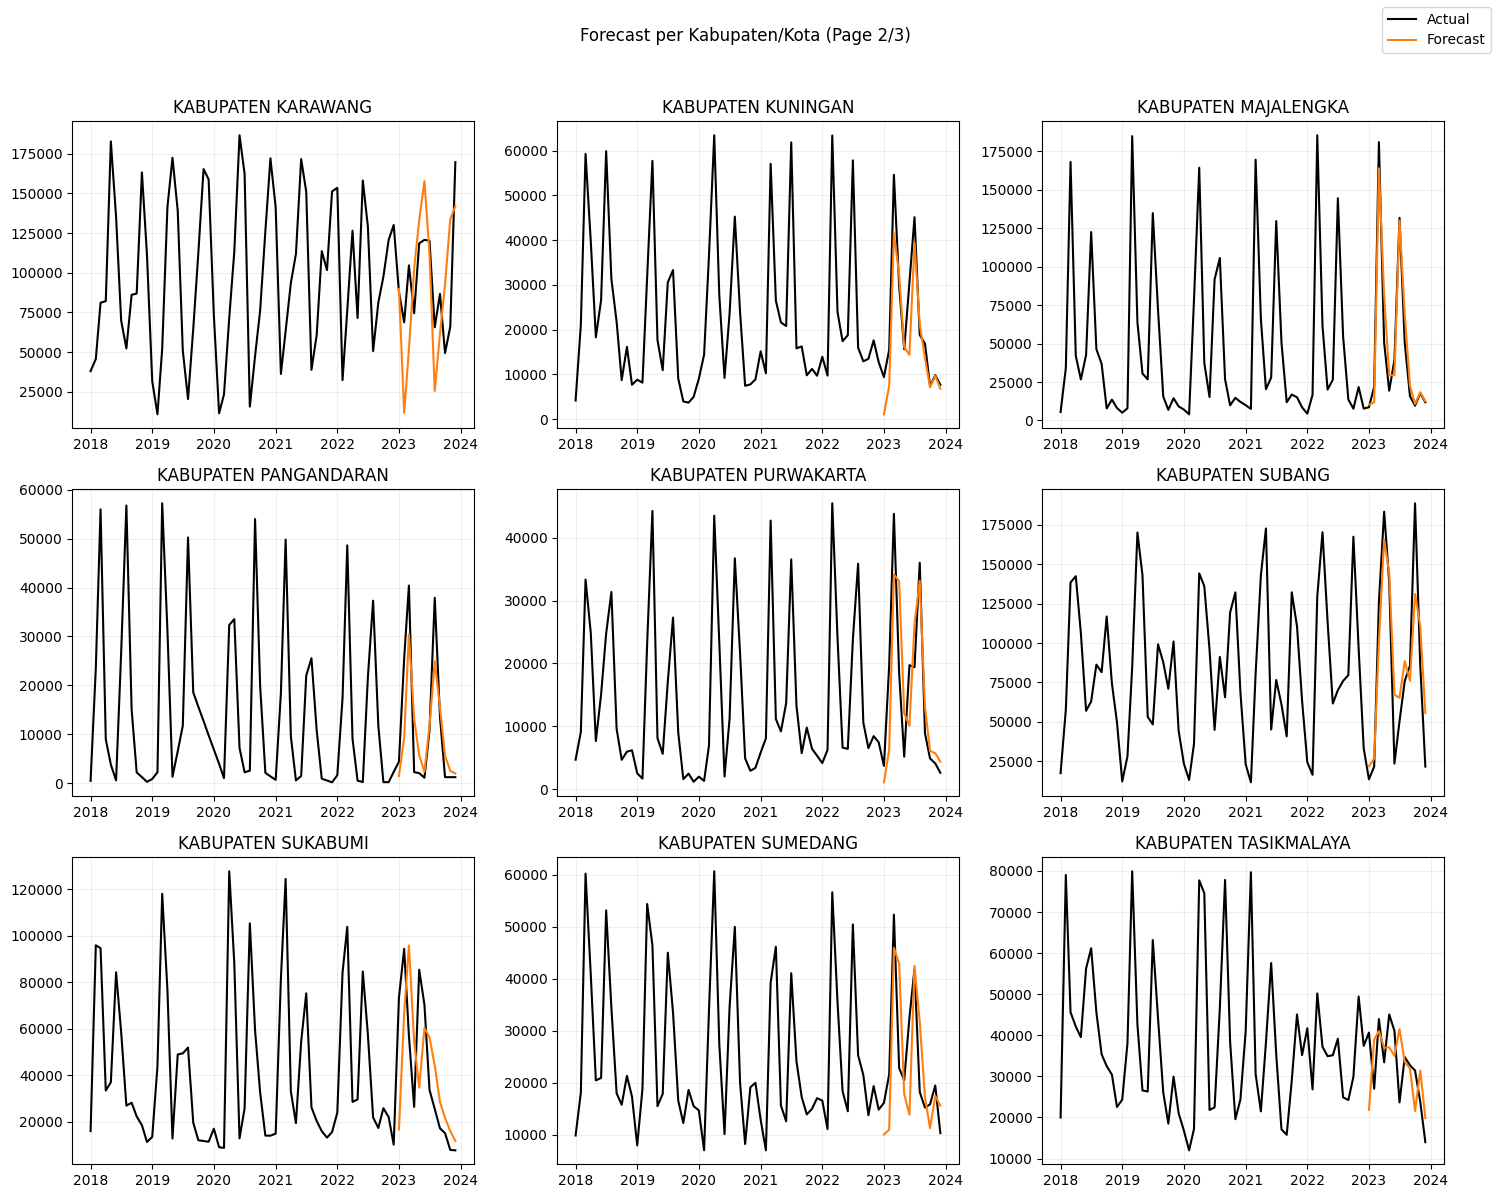

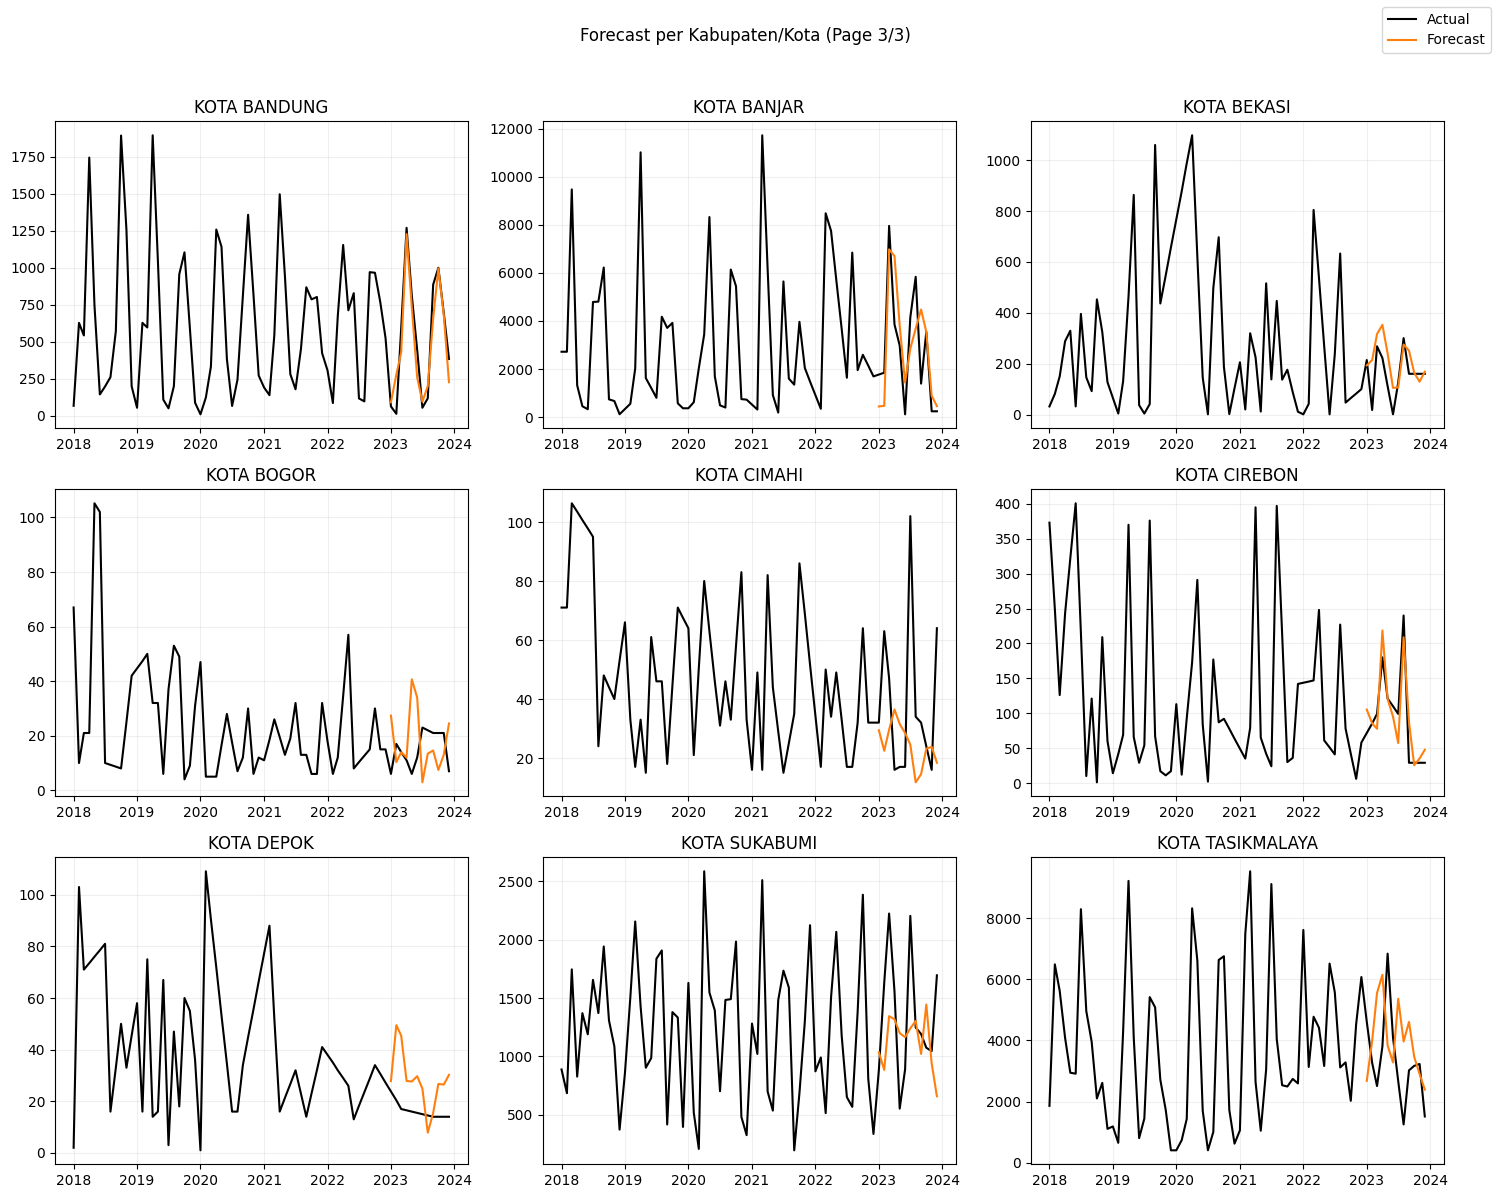

In [11]:
# Plot forecasts for all kabupaten/kota
import matplotlib.pyplot as plt
import math

# Ensure df_forecasts_all exists; if not, rebuild quickly from prior functions
try:
    _df_all = df_forecasts_all.copy()
except NameError:
    all_rows = []
    horizon_all = 12
    for kab in kabupaten_list:
        series_kab, freq_kab = build_series_for_kab(df, kab)
        res = holt_winters_forecast(series_kab, freq_kab, horizon=horizon_all)
        if len(res['test']) > 0:
            out_index = res['test'].index
        else:
            out_index = pd.date_range(series_kab.index.max() + pd.offsets.MonthBegin(1), periods=horizon_all, freq='MS')
        for dt, fc in zip(out_index, res['forecast'].values):
            all_rows.append({'nama_kabupaten_kota': kab, 'tanggal': dt, 'forecast': fc})
    _df_all = pd.DataFrame(all_rows).sort_values(['nama_kabupaten_kota','tanggal'])

# Plot in pages (to avoid huge single figure). 9 per page in 3x3 grid.
kabs = sorted(_df_all['nama_kabupaten_kota'].unique())
per_page = 9
pages = math.ceil(len(kabs) / per_page)
print(f'Total kabupaten: {len(kabs)}; pages: {pages}')

for p in range(pages):
    start = p * per_page
    end = min((p+1) * per_page, len(kabs))
    subset = kabs[start:end]
    n = len(subset)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=False)
    axes = axes.flatten()
    for i, kab in enumerate(subset):
        ax = axes[i]
        # actual series for kabupaten
        ser_kab, _ = build_series_for_kab(df, kab)
        ax.plot(ser_kab.index, ser_kab.values, color='black', label='Actual')
        # forecast overlay from _df_all
        d_kab = _df_all[_df_all['nama_kabupaten_kota'] == kab]
        ax.plot(d_kab['tanggal'], d_kab['forecast'], color='tab:orange', label='Forecast')
        ax.set_title(kab)
        ax.grid(alpha=0.2)
    # hide unused axes
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f'Forecast per Kabupaten/Kota (Page {p+1}/{pages})')
    plt.tight_layout(rect=[0, 0, 0.98, 0.96])
    plt.show()

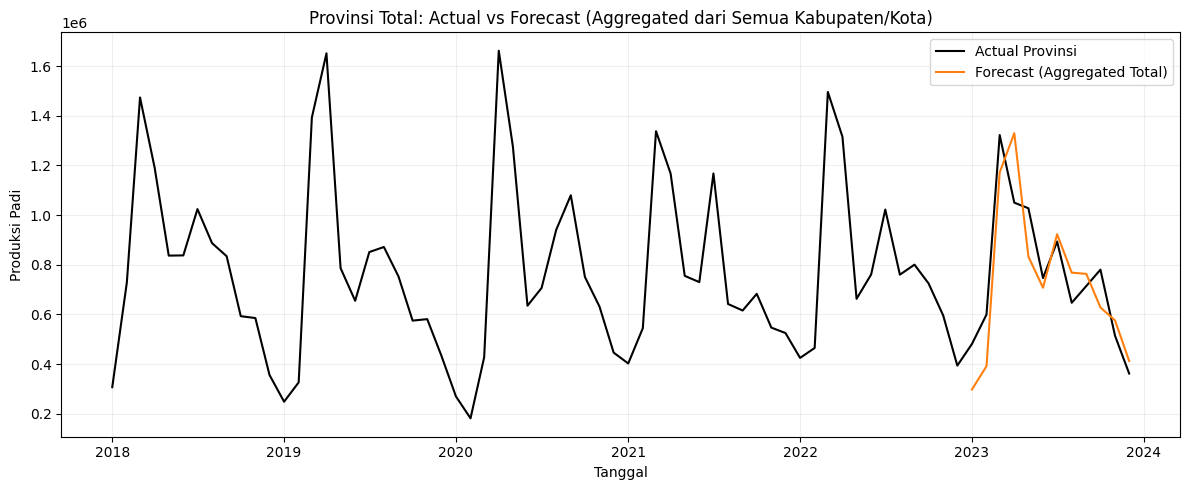

In [12]:
# Plot total (provinsi) forecast aggregated from all kabupaten/kota
import matplotlib.pyplot as plt

# Build actual provincial total from cleaned data
prov_actual = (df.groupby('date_parsed', as_index=False)['produksi_padi']
                 .sum()
                 .sort_values('date_parsed'))
prov_actual = prov_actual.set_index('date_parsed')['produksi_padi'].astype(float)

# Ensure df_forecasts_all exists; if not, rebuild quickly
try:
    _df_all = df_forecasts_all.copy()
except NameError:
    all_rows = []
    horizon_all = 12
    for kab in kabupaten_list:
        series_kab, freq_kab = build_series_for_kab(df, kab)
        res = holt_winters_forecast(series_kab, freq_kab, horizon=horizon_all)
        if len(res['test']) > 0:
            out_index = res['test'].index
        else:
            out_index = pd.date_range(series_kab.index.max() + pd.offsets.MonthBegin(1), periods=horizon_all, freq='MS')
        for dt, fc in zip(out_index, res['forecast'].values):
            all_rows.append({'nama_kabupaten_kota': kab, 'tanggal': dt, 'forecast': fc})
    _df_all = pd.DataFrame(all_rows)

# Aggregate kabupaten forecasts to provincial total per month
prov_forecast = (_df_all.groupby('tanggal', as_index=False)['forecast']
                 .sum()
                 .sort_values('tanggal'))
prov_forecast = prov_forecast.set_index('tanggal')['forecast'].astype(float)

# Plot actual vs aggregated forecast
plt.figure(figsize=(12,5))
plt.plot(prov_actual.index, prov_actual.values, label='Actual Provinsi', color='black')
plt.plot(prov_forecast.index, prov_forecast.values, label='Forecast (Aggregated Total)', color='tab:orange')
plt.title('Provinsi Total: Actual vs Forecast (Aggregated dari Semua Kabupaten/Kota)')
plt.xlabel('Tanggal')
plt.ylabel('Produksi Padi')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()